# Parallel normative modelling

This notebook will go through the options of the runner class. We will show how to fit and evaluate a model in parallel, and how to do cross-validation. 

This notebook is just an adaptation of the 'normative_modelling.ipynb' notebook, so it is recommended that you look at that one first.

The notebook is tailored to the Slurm environment on the Donders HPC cluster, but can be adapted to other Slurm or Torque environments. 


## Setting up the environment on the cluster

First, SSH into the cluster. If you are using VScode, you can use the Remote - SSH extension to connect to the cluster. It's a breeze. 

We start with a clean environment and install the PCNtoolkit package. We do this in an interactive job, because it is much faster than using a login node.

```bash
sbash --time=10:00:00 --mem=16gb -c 4 --ntasks-per-node=1
module load anaconda3
conda create -n pcntoolkit_cluster_tutorial python=3.12
source activate pcntoolkit_cluster_tutorial
pip install pcntoolkit
pip install ipykernel
pip install graphviz
```

Next, we want to use the newly created environment in our notebook. 

If you are running this notebook in VScode, you can select the environment by clicking on the mysterious symbol in the top right corner of the notebook. 

Click "Select Another Kernel...", "Python environments...", and then from the dropdown, select the `pcntoolkit_cluster_tutorial` environment. 

You may have to reload the window after creating the environment before it is available in VScode -> Open the command palette (mac: cmd+shift+P, windows: ctrl+shift+P) and type "Reload Window"

After selecting the environment, the weird symbol in the top right corner should now show the environment name. 

### Imports

In [4]:
import warnings
import logging

import pandas as pd
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model import NormativeModel
from pcntoolkit.regression_model.blr import BLR
from pcntoolkit.math.basis_function import BsplineBasisFunction
from pcntoolkit.util.runner import Runner
import numpy as np
import pcntoolkit.util.output
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# Get the conda environment path
conda_env_path = os.path.join(os.path.dirname(os.path.dirname(sys.executable)))
print(f"This should be the conda environment path: {conda_env_path}")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")
pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(True)

This should be the conda environment path: /project/3022000.05/projects/stijdboe/envs/pcntoolkit_cluster_tutorial


In [7]:

def load_lifespan_big():
    subject_ids = ['participant_id']
    covariates = ['age']
    batch_effects = ['sex', 'site']
    dtypes = {'participant_id': str, "group": str, "group2": str}
    for col in batch_effects:
        dtypes[col] = str
    for col in covariates:
        dtypes[col] = float
    data= pd.read_csv("/project_cephfs/3022017.06/projects/stijdboe/Data/sairut_data/lifespan_big.csv", dtype=dtypes)
    # Use the 5 largest sites
    # data = data[data['site_ID'].isin(data['site_ID'].value_counts().index[:5])]
    # Drop the columns that have only nan or null 
    data = data.dropna(axis=0, how='all', inplace=False)
    # Drop the rows that have any nan or null 
    data = data.dropna(axis=1, how='any', inplace=False)
    data["sex"] = data["sex"].map({"0.0": "Female", "1.0": "Male", "2.0": "Female"})
    data["site"] = data['site_ID']
    def is_response_var(str):
        print(str)
        i_respvar = str not in subject_ids and str not in covariates and str not in batch_effects and not str.startswith('site_') and not str.startswith('group') and not str.startswith('race')
        print(i_respvar)
        return i_respvar
    response_vars = [col for col in data.columns if is_response_var(col)]
    norm_data = NormData.from_dataframe(
        name="lifespan_big",
        dataframe=data,
        covariates=covariates,
        batch_effects=batch_effects,
        response_vars=response_vars,
        subject_ids=subject_ids
    )
    return norm_data


data = load_lifespan_big()


participant_id
False
age
False
sex
False
lh_G&S_frontomargin_thickness
True
lh_G&S_occipital_inf_thickness
True
lh_G&S_paracentral_thickness
True
lh_G&S_subcentral_thickness
True
lh_G&S_transv_frontopol_thickness
True
lh_G&S_cingul-Ant_thickness
True
lh_G&S_cingul-Mid-Ant_thickness
True
lh_G&S_cingul-Mid-Post_thickness
True
lh_G_cingul-Post-dorsal_thickness
True
lh_G_cingul-Post-ventral_thickness
True
lh_G_cuneus_thickness
True
lh_G_front_inf-Opercular_thickness
True
lh_G_front_inf-Orbital_thickness
True
lh_G_front_inf-Triangul_thickness
True
lh_G_front_middle_thickness
True
lh_G_front_sup_thickness
True
lh_G_Ins_lg&S_cent_ins_thickness
True
lh_G_insular_short_thickness
True
lh_G_occipital_middle_thickness
True
lh_G_occipital_sup_thickness
True
lh_G_oc-temp_lat-fusifor_thickness
True
lh_G_oc-temp_med-Lingual_thickness
True
lh_G_oc-temp_med-Parahip_thickness
True
lh_G_orbital_thickness
True
lh_G_pariet_inf-Angular_thickness
True
lh_G_pariet_inf-Supramar_thickness
True
lh_G_parietal_sup_

In [8]:
data.Y.values.shape

(57116, 4)

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [10]:

normdata = load_lifespan_big()

site_ID
ATT               31
ATV               77
CIN              136
CNP-35343.0      153
CNP-35426.0       79
               ...  
site21           491
site22            35
top              823
ukb-11025.0    24986
ukb-11027.0     9972
Length: 72, dtype: int64


In [7]:
normdata.response_vars.values

array(['lh_G&S_frontomargin_thickness', 'lh_G&S_occipital_inf_thickness',
       'lh_G&S_paracentral_thickness', 'lh_G&S_subcentral_thickness'],
      dtype='<U30')

In [8]:
data

NameError: name 'data' is not defined

In [18]:


# train, test = normdata.train_test_split(splits = [0.8, 0.2])
print(normdata.Y.values.mean(axis=0))


[nan nan nan nan]


Text(0, 0.5, "<xarray.DataArray 'response_vars' ()> Size: 48B\narray('lh_euler', dtype='<U12')\nCoordinates:\n    response_vars  <U12 48B 'lh_euler'")

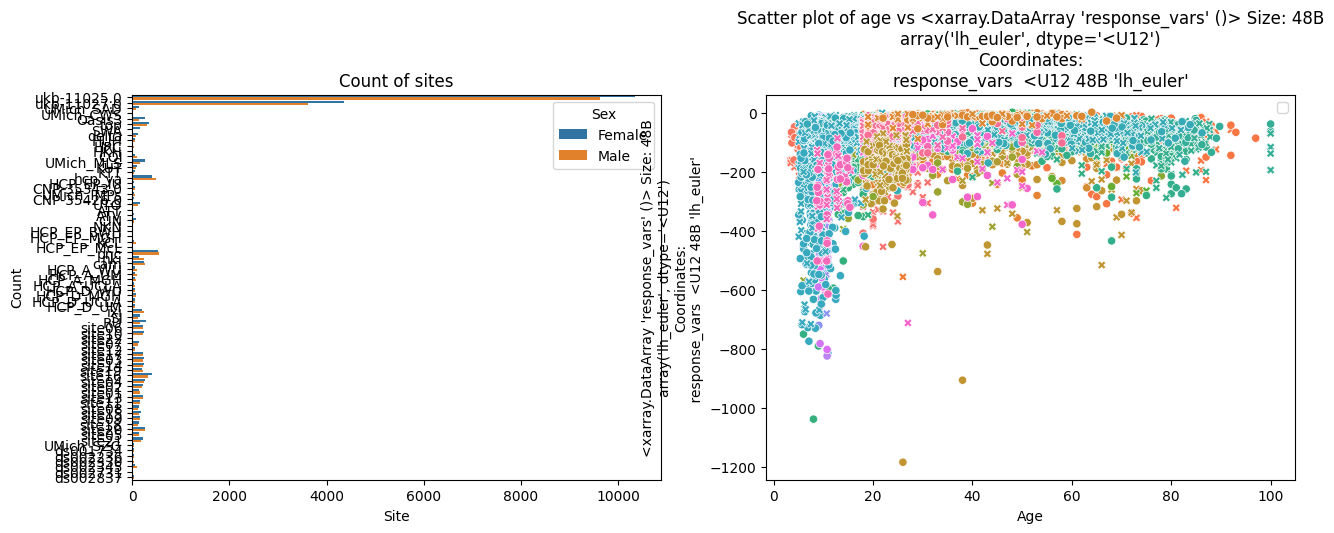

In [11]:
normdata = load_lifespan_big()
train, test = normdata.train_test_split(splits = [0.8, 0.2])
# Inspect the data
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")

sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", normdata.response_vars.values[0]),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {normdata.response_vars[0]}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(normdata.response_vars[0])

# plt.savefig(os.path.join(resource_dir, "lifespan_big_scatter.png"))

## Configure the regression model


In [12]:
# BLR model
blr_regression_model = BLR(
    name="template",
    n_iter=1000,
    tol=1e-8,
    optimizer="l-bfgs-b",
    l_bfgs_b_epsilon=0.1,
    l_bfgs_b_l=0.1,
    l_bfgs_b_norm="l2",
    fixed_effect=True,
    basis_function_mean=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    heteroskedastic=True,
    basis_function_var=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    fixed_effect_var=True,
    intercept=True,
    intercept_var=True,
)

In [13]:
model = NormativeModel(
    template_regression_model=blr_regression_model,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="resources/blr/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robustminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robustminmax", "none"
    outscaler="standardize",
)

## Fit the model
Normally we would just call 'fit_predict' on the model directly, but because we want to use the runner to do cross-validation in parallel, we need to first create a runner object. 

In [15]:
runner = Runner(
    cross_validate=False,
    parallelize=False,
    environment=conda_env_path,
    job_type="slurm",  # or "torque" if you are on a torque cluster
    n_jobs=2,
    time_limit="00:10:00",
    log_dir="resources/runner_output/log_dir",
    temp_dir="resources/runner_output/temp_dir",
)


The runner object will now fit the model in parallel, and save the results in save directories that it will create for each fold.

In [16]:
runner.fit_predict(model, train, test, observe=True)

Process: 3304146 - UUID for runner task created: b981589c-0081-4e7b-875d-f965ad9663a0
Process: 3304146 - Temporary directory created:
	/project/3022000.05/projects/stijdboe/Projects/PCNtoolkit/examples/resources/runner_output/temp_dir/b981589c-0081-4e7b-875d-f965ad9663a0
Process: 3304146 - Log directory created:
	/project/3022000.05/projects/stijdboe/Projects/PCNtoolkit/examples/resources/runner_output/log_dir/b981589c-0081-4e7b-875d-f965ad9663a0
Process: 3304146 - Fitting models on 4 response variables.
Process: 3304146 - Fitting model for lh_euler.
Process: 3304146 - Fitting model for rh_euler.
Process: 3304146 - Fitting model for lh_euler_neg.
Process: 3304146 - Fitting model for rh_euler_neg.
Process: 3304146 - Saving model to:
	resources/blr/save_dir.
Process: 3304146 - Making predictions on 4 response variables.
Process: 3304146 - Computing z-scores for 4 response variables.
Process: 3304146 - Computing z-scores for rh_euler.
Process: 3304146 - Computing z-scores for rh_euler_neg

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

Process: 3304146 - Making predictions on 4 response variables.
Process: 3304146 - Computing z-scores for 4 response variables.
Process: 3304146 - Computing z-scores for rh_euler.
Process: 3304146 - Computing z-scores for rh_euler_neg.
Process: 3304146 - Computing z-scores for lh_euler.
Process: 3304146 - Computing z-scores for lh_euler_neg.
Process: 3304146 - Making predictions on 4 response variables.
Process: 3304146 - Computing z-scores for 4 response variables.
Process: 3304146 - Computing z-scores for rh_euler.
Process: 3304146 - Computing z-scores for rh_euler_neg.
Process: 3304146 - Computing z-scores for lh_euler.
Process: 3304146 - Computing z-scores for lh_euler_neg.
Process: 3304146 - Computing centiles for 4 response variables.
Process: 3304146 - Computing centiles for rh_euler.
Process: 3304146 - Computing centiles for rh_euler_neg.
Process: 3304146 - Computing centiles for lh_euler.
Process: 3304146 - Computing centiles for lh_euler_neg.
Process: 3304146 - Computing centi

KeyboardInterrupt: 

### Loading a fold model
We can load a model for a specific fold by calling `load_model` on the runner object. This will return a `NormativeModel`, which we can inspect and use to predict on new data.


In [7]:
fitted_model = runner.load_model(1)
display(fitted_model)

## Model extension

BLR models can only be extended, not transferred (yet).


In [8]:
runner.extend_predict(model, transfer_train, transfer_test)


---------------------------------------------------------
              PCNtoolkit Job Status Monitor ®
---------------------------------------------------------
Task uuid: 889e4103-b842-4338-8589-292b83d282c8
---------------------------------------------------------
Job ID      Name          State      Time      Nodes
---------------------------------------------------------

46951640    ptk_job_0 COMPLETED                          
46951641    ptk_job_1 COMPLETED                          

---------------------------------------------------------
Total active jobs: 0
Total completed jobs: 2
Total failed jobs: 0
---------------------------------------------------------


---------------------------------------------------------
No more running jobs!
---------------------------------------------------------



Datasets with a zscores DataArray will have the `.plot_qq()` function available:

# More to do with the runner

The following functions are available:
- `transfer(transfer_data)`: Transfer the model to transfer_data.
- `extend(extend_data)`: Extend the model to extend_data.
- `transfer_predict(transfer_data, transfer_test)`: Transfer to transfer_test and predict on transfer_test.
- `extend_predict(extend_data, extend_test)`: Extend to extend_test and predict on extend_test.